In [75]:
#pip install protobuf==3.20.*

In [76]:
#import protobuf
#print(protobuf.__version__)
## 2.0.1

In [77]:
#install tfrs

#uncomment the code below to install tfrs
#!pip install -q tensorflow-recommenders

In [78]:
#import the necessary modules

import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import pandas as pd
import tensorflow as tf
#import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [79]:
#read csv files to pandas

#you can modify the path to your own path
df_airdrops = pd.read_csv('/Dataset Recommendation System - Task Dataset.csv', dtype={'task_id':'str'})
df_enrollments = pd.read_csv('/Dataset Recommendation System - Enrollment Dataset_enroll only.csv',  dtype={'user_id': 'str', 'task_id':'str'})

In [80]:
#check the dataframe

df_enrollments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           621 non-null    object
 1   user_name         621 non-null    object
 2   user_gender       621 non-null    object
 3   user_gender_bool  621 non-null    bool  
 4   is_employed       621 non-null    object
 5   is_employed_bool  621 non-null    bool  
 6   user_age_group    621 non-null    object
 7   user_level        621 non-null    object
 8   user_level_bool   621 non-null    bool  
 9   task_id           621 non-null    object
 10  task_title        621 non-null    object
 11  task_type         621 non-null    object
 12  enrollment        621 non-null    object
 13  enrollment_bool   621 non-null    bool  
dtypes: bool(4), object(10)
memory usage: 51.1+ KB


In [81]:
#convert the dataframe to a MapDataset

enrollments = tf.data.Dataset.from_tensor_slices(dict(df_enrollments)).map(lambda x: {
    "task_title": x["task_title"],
    "user_id": x["user_id"],
})

airdrops = tf.data.Dataset.from_tensor_slices(dict(df_airdrops)).map(lambda x: x["task_title"])

print(type(enrollments))
print(type(airdrops))



<class 'tensorflow.python.data.ops.map_op._MapDataset'>
<class 'tensorflow.python.data.ops.map_op._MapDataset'>


In [82]:
#shuffle the data

tf.random.set_seed(42)
shuffled = enrollments.shuffle(621, seed=42, reshuffle_each_iteration=False)
print(len(shuffled))

621


In [83]:
#divide the shuffled data into train and test set

train = shuffled.take(497)
test = shuffled.skip(497).take(124)

In [84]:
print(len(train))
print(len(test))

497
124


Let's also figure out unique user ids and movie titles present in the data. 

This is important because we need to be able to map the raw values of our categorical features to embedding vectors in our models. To do that, we need a vocabulary that maps a raw feature value to an integer in a contiguous range: this allows us to look up the corresponding embeddings in our embedding tables.

In [85]:
#unique_user_id = df_enrollments['user_id'].drop_duplicates().to_numpy()

In [86]:
#create arrays of unique airdrop titles and unique user ids to be used as vocabulary later

airdrop_titles = airdrops.batch(100)
user_ids = enrollments.batch(1000).map(lambda x: x["user_id"])

unique_airdrop_titles = np.unique(np.concatenate(list(airdrop_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print(unique_airdrop_titles[:10])
#unique_user_ids[:10]

[b'BNB Doge' b'Binance' b'Bybit' b'Cashmerlabs' b'Catly.io' b'Cloud Base'
 b'Credit Dao' b'ETHOS' b'Elixir Protocol' b'Ftx']


In [87]:
print(type(unique_airdrop_titles))
print(type(unique_user_ids))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [88]:
print(len(unique_airdrop_titles))
print(len(unique_user_ids))

30
100


## Implementing a model

Choosing the architecture of our model is a key part of modelling.

Because we are building a two-tower retrieval model, we can build each tower separately and then combine them in the final model.

### The query tower

Let's start with the query tower.

The first step is to decide on the dimensionality of the query and candidate representations:

In [89]:
#set the embedding dimension

embedding_dimension = 32

Higher values will correspond to models that may be more accurate, but will also be slower to fit and more prone to overfitting.

The second is to define the model itself. Here, we're going to use Keras preprocessing layers to first convert user ids to integers, and then convert those to user embeddings via an `Embedding` layer. Note that we use the list of unique user ids we computed earlier as a vocabulary:

In [90]:
#define the user model to embed the user ids as the query tower

user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

A simple model like this corresponds exactly to a classic [matrix factorization](https://ieeexplore.ieee.org/abstract/document/4781121) approach. While defining a subclass of `tf.keras.Model` for this simple model might be overkill, we can easily extend it to an arbitrarily complex model using standard Keras components, as long as we return an `embedding_dimension`-wide output at the end.

### The candidate tower

We can do the same with the candidate tower.

In [91]:
#define the airdrop model to embed the airdrop titles as the candidate tower

airdrop_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_airdrop_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_airdrop_titles) + 1, embedding_dimension)
])

### Metrics

In our training data we have positive (user, movie) pairs. To figure out how good our model is, we need to compare the affinity score that the model calculates for this pair to the scores of all the other possible candidates: if the score for the positive pair is higher than for all other candidates, our model is highly accurate.

To do this, we can use the `tfrs.metrics.FactorizedTopK` metric. The metric has one required argument: the dataset of candidates that are used as implicit negatives for evaluation.

In our case, that's the `movies` dataset, converted into embeddings via our movie model:

In [92]:
#define the metrics as FactorizedTopK (Top1, Top5, Top10, Top50, Top100)

metrics = tfrs.metrics.FactorizedTopK(
  candidates=airdrops.batch(128).map(airdrop_model)
)

### Loss

The next component is the loss used to train our model. TFRS has several loss layers and tasks to make this easy.

In this instance, we'll make use of the `Retrieval` task object: a convenience wrapper that bundles together the loss function and metric computation:

In [93]:
#define task to get loss function

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

The task itself is a Keras layer that takes the query and candidate embeddings as arguments, and returns the computed loss: we'll use that to implement the model's training loop.

### The full model

We can now put it all together into a model. TFRS exposes a base model class (`tfrs.models.Model`) which streamlines building models: all we need to do is to set up the components in the `__init__` method, and implement the `compute_loss` method, taking in the raw features and returning a loss value.

The base model will then take care of creating the appropriate training loop to fit our model.

In [94]:
#combine the query tower and candidate tower to build a full model

class AirdropsModel(tfrs.Model):

  def __init__(self, user_model, airdrop_model):
    super().__init__()
    self.airdrop_model: tf.keras.Model = airdrop_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_airdrop_embeddings = self.airdrop_model(features["task_title"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_airdrop_embeddings)

  def get_config(self):
    return {
        "user_model": self.user_model,
        "airdrop_model": self.airdrop_model,
        "task": self.task
    }


The `tfrs.Model` base class is a simply convenience class: it allows us to compute both training and test losses using the same method.

Under the hood, it's still a plain Keras model. You could achieve the same functionality by inheriting from `tf.keras.Model` and overriding the `train_step` and `test_step` functions (see [the guide](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) for details):

In these tutorials, however, we stick to using the `tfrs.Model` base class to keep our focus on modelling and abstract away some of the boilerplate.

## Fitting and evaluating

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Let's first instantiate the model.

In [95]:
#instantiate the model

model = AirdropsModel(user_model, airdrop_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

Then shuffle, batch, and cache the training and evaluation data.

In [96]:
#cache both train and test dataset

cached_train = train.shuffle(621).batch(128).cache()
cached_test = test.batch(64).cache()

Then train the  model:

In [97]:
#train the model
train_history = model.fit(cached_train, epochs=100)


Epoch 1/100
4/4 [==============================] - 1s 53ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0644 - factorized_top_k/top_10_categorical_accuracy: 0.2716 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 586.3874 - regularization_loss: 0.0000e+00 - total_loss: 586.3874
Epoch 2/100
4/4 [==============================] - 0s 51ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.2656 - factorized_top_k/top_10_categorical_accuracy: 0.7002 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 580.5542 - regularization_loss: 0.0000e+00 - total_loss: 580.5542
Epoch 3/100
4/4 [==============================] - 0s 51ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy:

Plot Training Loss and Training Accuracy

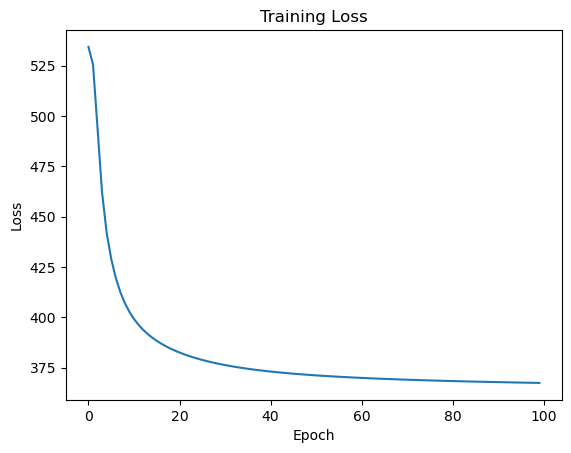

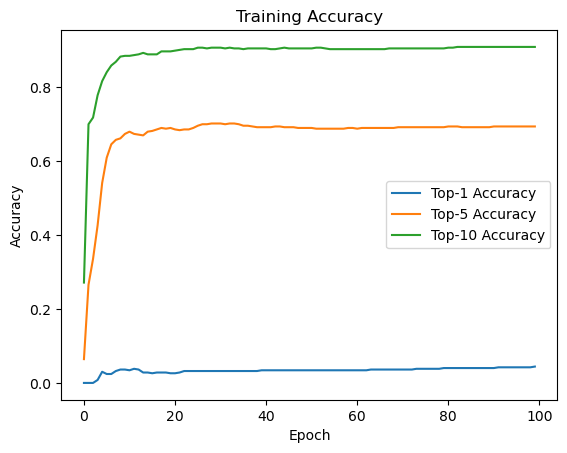

In [98]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(train_history.history["loss"])
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Plot the accuracy metrics
for metric in ["factorized_top_k/top_1_categorical_accuracy", "factorized_top_k/top_5_categorical_accuracy", "factorized_top_k/top_10_categorical_accuracy"]:
    plt.plot(train_history.history[metric])
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Top-1 Accuracy", "Top-5 Accuracy", "Top-10 Accuracy"])
plt.show()


If you want to monitor the training process with TensorBoard, you can add a TensorBoard callback to fit() function and then start TensorBoard using `%tensorboard --logdir logs/fit`. Please refer to [TensorBoard documentation](https://www.tensorflow.org/tensorboard/get_started) for more details.

As the model trains, the loss is falling and a set of top-k retrieval metrics is updated. These tell us whether the true positive is in the top-k retrieved items from the entire candidate set. For example, a top-5 categorical accuracy metric of 0.2 would tell us that, on average, the true positive is in the top 5 retrieved items 20% of the time.

Note that, in this example, we evaluate the metrics during training as well as evaluation. Because this can be quite slow with large candidate sets, it may be prudent to turn metric calculation off in training, and only run it in evaluation.

Finally, we can evaluate our model on the test set:

In [99]:
#evaluate the model on the test dataset

model.evaluate(cached_test, return_dict=True)

2/2 [==============================] - 0s 53ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.1613 - factorized_top_k/top_10_categorical_accuracy: 0.4355 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 471.7342 - regularization_loss: 0.0000e+00 - total_loss: 471.7342


{'factorized_top_k/top_1_categorical_accuracy': 0.0,
 'factorized_top_k/top_5_categorical_accuracy': 0.16129031777381897,
 'factorized_top_k/top_10_categorical_accuracy': 0.4354838728904724,
 'factorized_top_k/top_50_categorical_accuracy': 1.0,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 461.57440185546875,
 'regularization_loss': 0,
 'total_loss': 461.57440185546875}

Test set performance is much worse than training performance. This is due to two factors:

1. Our model is likely to perform better on the data that it has seen, simply because it can memorize it. This overfitting phenomenon is especially strong when models have many parameters. It can be mediated by model regularization and use of user and movie features that help the model generalize better to unseen data.
2. The model is re-recommending some of users' already watched movies. These known-positive watches can crowd out test movies out of top K recommendations.

The second phenomenon can be tackled by excluding previously seen movies from test recommendations. This approach is relatively common in the recommender systems literature, but we don't follow it in these tutorials. If not recommending past watches is important, we should expect appropriately specified models to learn this behaviour automatically from past user history and contextual information. Additionally, it is often appropriate to recommend the same item multiple times (say, an evergreen TV series or a regularly purchased item).

## Making predictions

Now that we have a model, we would like to be able to make predictions. We can use the `tfrs.layers.factorized_top_k.BruteForce` layer to do this.

In [100]:
# Create a model that takes in user id and recommends airdrop jobs out of the entire airdrop jobs.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
  tf.data.Dataset.zip((airdrops.batch(100), airdrops.batch(100).map(model.airdrop_model)))
)

In [101]:
# Get recommendations.
userid = 42
_, titles = index(tf.constant([str(userid)]))
recommended_titles = []

for airdrop in titles:
  print(airdrop)

tf.Tensor(
[b'Viva Leva' b'Cashmerlabs' b'Turbos Finance' b'ETHOS' b'Hashgreenswap'
 b'Cloud Base' b'Fusion Finance' b'GiroSwap' b'Elixir Protocol'
 b'Mantle Testnet'], shape=(10,), dtype=string)


In [102]:
print(type(titles))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [103]:
titles = titles.numpy().tolist()
print(type(titles))

<class 'list'>


In [104]:
print(titles)

[[b'Viva Leva', b'Cashmerlabs', b'Turbos Finance', b'ETHOS', b'Hashgreenswap', b'Cloud Base', b'Fusion Finance', b'GiroSwap', b'Elixir Protocol', b'Mantle Testnet']]


In [105]:
df_target_user = df_enrollments[df_enrollments['user_id']==str(userid)]
df_target_user

,user_id,user_name,user_gender,user_gender_bool,is_employed,is_employed_bool,user_age_group,user_level,user_level_bool,task_id,task_title,task_type,enrollment,enrollment_bool
366,42,Layla,Female,False,Employed,True,B,Experienced,True,2,Scroll Testnet,Testnet,Yes,True
367,42,Layla,Female,False,Employed,True,B,Experienced,True,3,Zetachain,Testnet,Yes,True
368,42,Layla,Female,False,Employed,True,B,Experienced,True,8,Viva Leva,Testnet,Yes,True
369,42,Layla,Female,False,Employed,True,B,Experienced,True,9,Cashmerlabs,Testnet,Yes,True
370,42,Layla,Female,False,Employed,True,B,Experienced,True,11,Turbos Finance,Testnet,Yes,True


In [106]:
print(titles[0][0])
new0 = str(titles[0][0]).replace('b\'', '')
new0 = new0.replace('\'', '')
print(new0)


b'Viva Leva'
Viva Leva


In [107]:
#define a function to filter out recommended airdrop jobs that the user has already enrolled

def delete_enrolled_tasks(userid, titles):
  titles = titles.numpy().tolist()
  recommended_titles = []
  for i in range(len(titles[0])):
    has_been_enrolled = False
    cleaned_title = str(titles[0][i]).replace('b\'', '')
    cleaned_title = cleaned_title.replace('\'', '')
    for task_enrolled in df_enrollments[df_enrollments['user_id']==str(userid)].task_title:
      if cleaned_title == task_enrolled:
        has_been_enrolled = True
        break
    if not has_been_enrolled: 
      recommended_titles.append(cleaned_title)
      print(cleaned_title)
      #print('a')
  return recommended_titles
        

#for task_finished in df_enrollments[df_enrollments['user_id']==str(userid)].task_id:
 # print(task_finished)

In [108]:
print(len(titles[0]))

10


In [109]:
print(titles[0][0])
cleaned_title = str(titles[0][0]).replace('b\'', '')
cleaned_title = cleaned_title.replace('\'', '')
print(cleaned_title)

b'Viva Leva'
Viva Leva


In [110]:
#recommended_titles = delete_enrolled_tasks(42,titles)

In [111]:
#delete_enrolled_tasks(42,titles)

In [112]:
#print(recommended_titles)

In [113]:
#print(f"Recommendations for user 42: {recommended_titles[:3]}")

Of course, the `BruteForce` layer is going to be too slow to serve a model with many possible candidates. The following sections shows how to speed this up by using an approximate retrieval index.

## Model serving

After the model is trained, we need a way to deploy it.

In a two-tower retrieval model, serving has two components:

- a serving query model, taking in features of the query and transforming them into a query embedding, and
- a serving candidate model. This most often takes the form of an approximate nearest neighbours (ANN) index which allows fast approximate lookup of candidates in response to a query produced by the query model.

In TFRS, both components can be packaged into a single exportable model, giving us a model that takes the raw user id and returns the titles of top movies for that user. This is done via exporting the model to a `SavedModel` format, which makes it possible to serve using [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).

To deploy a model like this, we simply export the `BruteForce` layer we created above:

In [114]:
# Export the query model.
with tempfile.TemporaryDirectory() as tmp:
  path = os.path.join(tmp, "model")
  path = os.path.join("sample_data/", "model")

  # Save the index.
  tf.saved_model.save(index, path)

  # Load it back; can also be done in TensorFlow Serving.
  loaded = tf.saved_model.load(path)

  # Pass a user id in, get top predicted movie titles back.
  scores, titles = loaded(["42"])

  print(f"Recommendations: {titles[0][:3]}")

INFO:tensorflow:Assets written to: sample_data/model\assets


INFO:tensorflow:Assets written to: sample_data/model\assets


Recommendations: [b'Viva Leva' b'Cashmerlabs' b'Turbos Finance']


In [115]:
#export the model into a .h5 file

#path = os.path.join(tmp, "model")
#path = os.path.join("sample_data/", "model")
path = "the_exported_model/my_model.h5"

# Save the index.
tf.saved_model.save(index, path)

INFO:tensorflow:Assets written to: the_exported_model/my_model.h5\assets


INFO:tensorflow:Assets written to: the_exported_model/my_model.h5\assets


In [118]:
# Save the user and airdrop models to .h5 files
user_model.save("user_model.h5")
airdrop_model.save("airdrop_model.h5")


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Check point Dirzy

You can delate this markdown

In [116]:
# Load it back; can also be done in TensorFlow Serving.
loaded = tf.saved_model.load(path)

# Pass a user id in, get top predicted airdrop titles back.
userid = 42
scores, titles = loaded([str(userid)])

recommended_titles = delete_enrolled_tasks(userid, titles)

#get top 3 recommended airdrops
print(f"Recommendations: {recommended_titles[:3]}")

ETHOS
Hashgreenswap
Cloud Base
Fusion Finance
GiroSwap
Elixir Protocol
Mantle Testnet
Recommendations: ['ETHOS', 'Hashgreenswap', 'Cloud Base']


In [117]:
model.save('the_model.h5')

NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

In [ ]:
import shutil
shutil.make_archive('the_exported_model2', 'zip', 'the_exported_model')

In [ ]:
tf.keras.models.save_model(index, 'content/test_model')

In [ ]:
tf.keras.models.save_model(model, 'content/test_model2')

In [ ]:
model.save("content_model", save_format='tf')

In [ ]:
shutil.make_archive('content/modelsavedwithkerasmeta', 'zip', 'content/test_model')

In [ ]:
model.save_weights('content_model_weights', save_format='tf')

In [ ]:
loaded_model = AirdropsModel(user_model, airdrop_model)
loaded_model.load_weights('content_model_weights')

In [ ]:
userid = 42
scores, titles = loaded_model([str(userid)])

recommended_titles = delete_enrolled_tasks(userid, titles)

#get top 3 recommended airdrops
print(f"Recommendations: {recommended_titles[:3]}")